Extracting HOG features...


Processing images:  96%|█████████████████████████████████████████████████████▋  | 11033/11502 [01:35<00:04, 115.39it/s]


Extracted 6000 samples with 8100 features each
Training SVM classifier...
Scaling features...
Training complete
Evaluating model...
Test Accuracy: 0.377

Classification Report:
              precision    recall  f1-score   support

        Ants       0.37      0.33      0.35       100
        Bees       0.53      0.51      0.52       100
     Beetles       0.30      0.30      0.30       100
Caterpillars       0.28      0.21      0.24       100
  Earthworms       0.28      0.34      0.31       100
     Earwigs       0.27      0.17      0.21       100
Grasshoppers       0.29      0.45      0.35       100
       Moths       0.60      0.61      0.61       100
       Slugs       0.31      0.26      0.28       100
      Snails       0.57      0.50      0.53       100
       Wasps       0.30      0.39      0.34       100
     Weevils       0.45      0.45      0.45       100

    accuracy                           0.38      1200
   macro avg       0.38      0.38      0.37      1200
weighted av

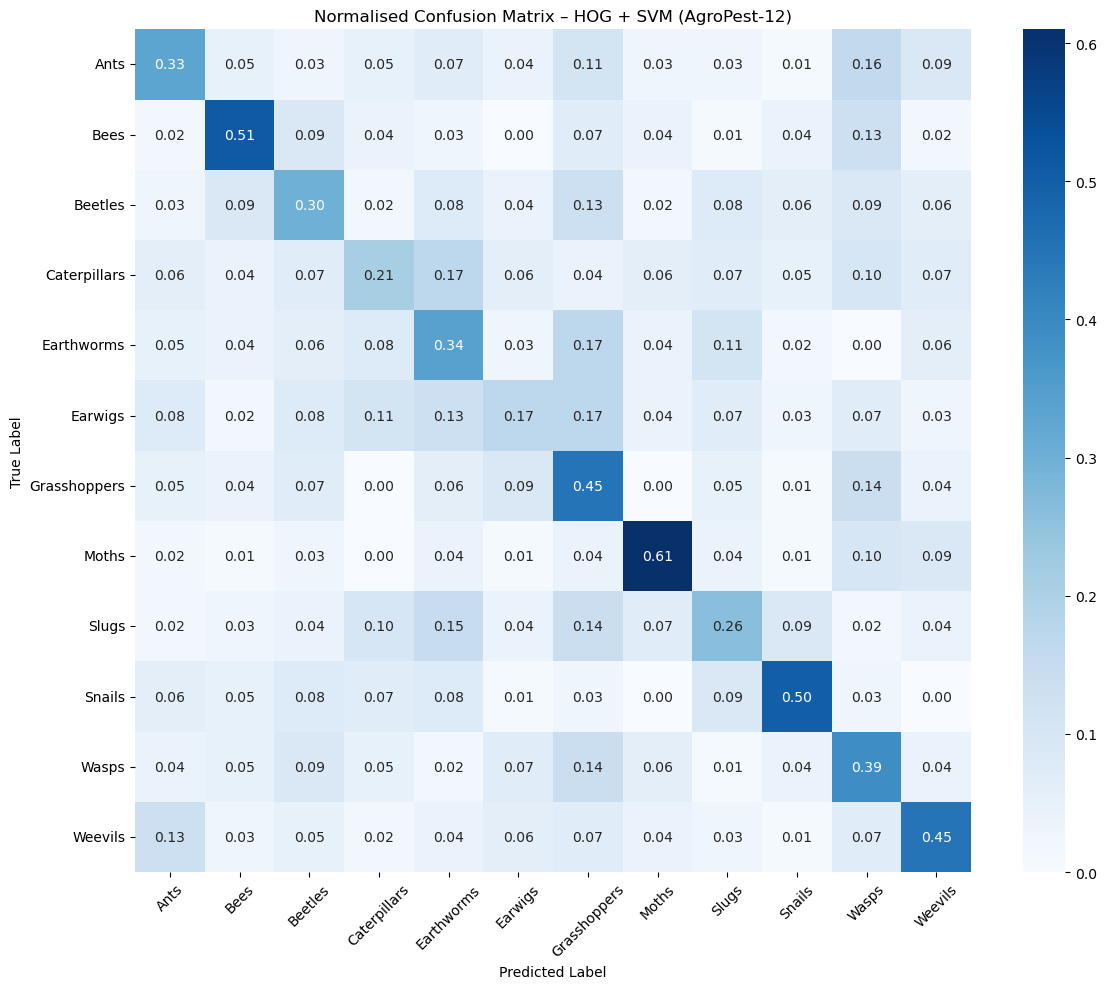

Model saved to outputs/hog_svm_model.pkl
Evaluation report saved to outputs/hog_svm_report.txt


In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

class HOGSVMInsectClassifier:
    def __init__(self):
        self.classes = [
            "Ants", "Bees", "Beetles", "Caterpillars", "Earthworms", "Earwigs",
            "Grasshoppers", "Moths", "Slugs", "Snails", "Wasps", "Weevils"
        ]
        self.img_size = (128, 128)
        self.hog_params = {
            'orientations': 9,
            'pixels_per_cell': (8, 8),
            'cells_per_block': (2, 2),
            'block_norm': 'L2-Hys',
            'transform_sqrt': True, 
            'feature_vector': True
        }
        self.scaler = StandardScaler()
        self.clf = None
        
    def extract_roi(self, img, bbox, h, w):
        cid, xc, yc, bw, bh = bbox
        
        # convert normalised coordinates to pixel coordinates
        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)
        
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        
        # extract and check crop
        crop = img[y1:y2, x1:x2]
        if crop.size == 0:
            return None
            
        return crop
    
    def preprocess_image(self, crop):
        # resize to standard size
        gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, self.img_size)
        
        # apply Gaussian blur 
        gray = cv2.GaussianBlur(gray, (3, 3), 0)
        
        # apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        
        return gray
    
    def extract_hog_features(self, img_dir, lbl_dir, max_samples_per_class=1000):
        X, y = [], []
        img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        
        class_counts = {cls: 0 for cls in self.classes}
        
        print("Extracting HOG features...")
        for img_name in tqdm(img_files, desc="Processing images"):
            if len(X) >= len(self.classes) * max_samples_per_class:
                break
                
            lbl_name = img_name.replace('.jpg', '.txt')
            img_path = os.path.join(img_dir, img_name)
            lbl_path = os.path.join(lbl_dir, lbl_name)
            
            if not os.path.exists(lbl_path):
                continue
                
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            h, w = img.shape[:2]
            
            with open(lbl_path, 'r') as f:
                bbox_lines = f.readlines()
            
            for line in bbox_lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                    
                bbox = list(map(float, parts))
                class_id = int(bbox[0])
                class_name = self.classes[class_id]
                
                if class_counts[class_name] >= max_samples_per_class:
                    continue
                
                # extract ROI
                crop = self.extract_roi(img, bbox, h, w)
                if crop is None:
                    continue
                
                # extract HOG features
                processed = self.preprocess_image(crop)
                features = hog(processed, **self.hog_params)
                
                X.append(features)
                y.append(class_name)
                class_counts[class_name] += 1
                
                if class_counts[class_name] >= max_samples_per_class:
                    break
        
        return np.array(X), np.array(y)
    
    def train(self, X, y, test_size=0.2):
        print("Training SVM classifier...")
        
        # split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=42
        )
        
        # scale features
        print("Scaling features...")
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # SVM parameters
        self.clf = SVC(
            kernel='rbf', 
            C=1.0,
            class_weight='balanced',  
            probability=True,
            random_state=42
        )
                
        # train final model
        self.clf.fit(X_train_scaled, y_train)
        print("Training complete")
        
        return X_test_scaled, y_test
    
    def evaluate(self, X_test, y_test):
        if self.clf is None:
            raise ValueError("Model not trained yet!")
            
        print("Evaluating model...")
        y_pred = self.clf.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Test Accuracy: {accuracy:.3f}")
        
        report = classification_report(y_test, y_pred)
        print("\nClassification Report:")
        print(report)
        
        # confusion matrix
        self.plot_confusion_matrix(y_test, y_pred)
        
        return accuracy, report
    
  
    def plot_confusion_matrix(self, y_true, y_pred):
        # normalise by true class
        cm = confusion_matrix(
            y_true, 
            y_pred, 
            labels=self.classes,
            normalize='true'
        )

        plt.figure(figsize=(12, 10))
        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=self.classes,
            yticklabels=self.classes
        )

        plt.title("Normalised Confusion Matrix – HOG + SVM (AgroPest-12)")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig("outputs/hog_svm_confusion_matrix_normalised.png", dpi=300)
        plt.show()

    
    def save_model(self, path='outputs/hog_svm_model.pkl'):
        model_data = {
            'classifier': self.clf,
            'scaler': self.scaler,
            'classes': self.classes,
            'hog_params': self.hog_params,
            'img_size': self.img_size
        }
        
        joblib.dump(model_data, path)
        print(f"Model saved to {path}")
    
    def load_model(self, path='outputs/hog_svm_model.pkl'):
        model_data = joblib.load(path)
        self.clf = model_data['classifier']
        self.scaler = model_data['scaler']
        self.classes = model_data['classes']
        self.hog_params = model_data['hog_params']
        self.img_size = model_data['img_size']
        print(f"Model loaded from {path}")
    
    def predict_single_image(self, image_path):
        if self.clf is None:
            raise ValueError("Model not loaded!")
        
        # load and preprocess image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not load image from {image_path}")
        
        processed = self.preprocess_image(img)
        features = hog(processed, **self.hog_params)
        features_scaled = self.scaler.transform([features])
        
        prediction = self.clf.predict(features_scaled)[0]
        probabilities = self.clf.predict_proba(features_scaled)[0]
        
        top3_indices = np.argsort(probabilities)[-3:][::-1]
        top3_predictions = [
            (self.classes[i], probabilities[i]) 
            for i in top3_indices
        ]
        
        return prediction, top3_predictions

def main():
    os.makedirs("outputs", exist_ok=True)
    
    # init classifier
    classifier = HOGSVMInsectClassifier()
    
    DATA_ROOT = "archive/train"
    IMG_DIR = os.path.join(DATA_ROOT, "images")
    LBL_DIR = os.path.join(DATA_ROOT, "labels")
    
    try:
        # wxtract the features
        X, y = classifier.extract_hog_features(IMG_DIR, LBL_DIR, max_samples_per_class=500)
        print(f"Extracted {len(X)} samples with {len(X[0])} features each")
        
        np.save("outputs/hog_features.npy", X)
        np.save("outputs/hog_labels.npy", y)
        
        # training
        X_test, y_test = classifier.train(X, y)
        
        # evaluate
        accuracy, report = classifier.evaluate(X_test, y_test)
        
        # save model
        classifier.save_model()
        
        # Save evaluation report
        with open('outputs/hog_svm_report.txt', 'w') as f:
            f.write("HOG + SVM Classification Report\n")
            f.write("=" * 50 + "\n")
            f.write(f"Overall Accuracy: {accuracy:.3f}\n\n")
            f.write("Detailed Report:\n")
            f.write(report)
        
        print("Evaluation report saved to outputs/hog_svm_report.txt")
        
    except Exception as e:
        print(f"Error: {e}")
        raise

if __name__ == "__main__":
    main()